In [4]:
!git clone https://github.com/omar-florez/scratch_mlp/

Cloning into 'scratch_mlp'...
remote: Enumerating objects: 716, done.
remote: Total 716 (delta 0), reused 0 (delta 0), pack-reused 716 (from 1)
Receiving objects: 100% (716/716), 74.93 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (432/432), done.
Updating files: 100% (74/74), done.


In [1]:
#@title Prelims: Install Libraries
!pip3 install ipdb
!pip3 install imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00


In [12]:
#@title Prelims: Load Libraries (they're all pre-installed in colab)
import os
import numpy as np
from scratch_mlp import utils
import shutil
import random

from IPython.display import Image
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

%matplotlib inline

In [13]:
def reset_folders():
    folders = [os.path.join('./scratch_mlp/plots', f) for f in ['loss', 'gif', 'all', 'accuracy', 'boundary']]
    if not os.path.exists('./scratch_mlp/plots'):
        os.mkdir('./scratch_mlp/plots')
    for f in folders:
        if os.path.exists(f):
            shutil.rmtree(f)
        os.mkdir(f)
        print(f)

def load_XOR_data(N=300):
    rng = np.random.RandomState(0)
    X = rng.randn(N, 2)
    y = np.array(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), dtype=int)
    y = np.expand_dims(y, 1)
    y_hot_encoded = []

    for x in y:
        if x == 0:
            y_hot_encoded.append([1,0])
        else:
            y_hot_encoded.append([0, 1])
    return X, np.array(y_hot_encoded)

def sigmoid(z, first_derivative=False):
    if first_derivative:
        return z*(1.0-z)
    return 1.0/(1.0+np.exp(-z))

def tanh(z, first_derivative=True):
    if first_derivative:
        return (1.0-z*z)
    return (1.0-np.exp(-z))/(1.0+np.exp(-z))

def inference(data, weights):
    h1 = sigmoid(np.matmul(data, weights[0]))
    logits = np.matmul(h1, weights[1])
    probs = np.exp(logits)/np.sum(np.exp(logits), axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [8]:
import ipdb
def run():
    #size of minibatch: int(X.shape[0])
    N = 80
    X, y = load_XOR_data(N=800)
    input_dim = int(X.shape[1])
    hidden_dim = 50
    output_dim = 2
    num_epochs = 2000
    learning_rate= 1e-1
    reg_coeff = 1e-6
    losses = []
    accuracies=[]

    #---------------------------------------------------------------------------------------------------------------
    # Initialize weights:
    np.random.seed(1)
    w1 = 2.0*np.random.random((input_dim, hidden_dim))-1.0      #w0=(2,hidden_dim)
    w2 = 2.0*np.random.random((hidden_dim, output_dim))-1.0     #w1=(hidden_dim,2)

    #Calibratring variances with 1/sqrt(fan_in)
    w1 #/= (np.sqrt(input_dim)*1.0)
    w2 /= np.sqrt(hidden_dim)

    for i in range(num_epochs):
        #is want to shuffle indices: np.random.shuffle(index)
        index = np.arange(X.shape[0])
        index = random.sample(list(index), N)
        #np.random.shuffle(index)

        #---------------------------------------------------------------------------------------------------------------
        # Forward step:
        h1 = sigmoid(np.matmul(X[index], w1))                   #(N, 3)
        logits = sigmoid(np.matmul(h1, w2))                     #(N, 2)
        probs = np.exp(logits)/np.sum(np.exp(logits), axis=1, keepdims=True)
        h2 = logits

        #---------------------------------------------------------------------------------------------------------------
        # Definition of Loss function: mean squared error plus Ridge regularization
        L = np.square(y[index]-logits).sum()/(2*N) + reg_coeff*(np.square(w1).sum()+np.square(w2).sum())/(2*N)

        losses.append([i,L])

        #---------------------------------------------------------------------------------------------------------------
        # Backward step: Error = W_l e_l+1 f'_l
        #       dL/dw2 = dL/dh2 * dh2/dz2 * dz2/dw2
        dL_dh2 = -(y[index] - logits)                            #(N, 2)
        dh2_dz2 = sigmoid(h2, first_derivative=True)            #(N, 2)
        dz2_dw2 = h1                                            #(N, hidden_dim)
        #Gradient for weight2:   (hidden_dim,N)x(N,2)*(N,2)
        dL_dw2 = dz2_dw2.T.dot(dL_dh2*dh2_dz2) + reg_coeff*np.square(w2).sum()

        #dL/dw1 = dL/dh1 * dh1/dz1 * dz1/dw1
        #       dL/dh1 = dL/dz2 * dz2/dh1
        #       dL/dz2 = dL/dh2 * dh2/dz2
        dL_dz2 = dL_dh2 * dh2_dz2                               #(N, 2)
        dz2_dh1 = w2                                            #z2 = h1*w2
        dL_dh1 =  dL_dz2.dot(dz2_dh1.T)                         #(N,2)x(2, hidden_dim)=(N, hidden_dim)
        dh1_dz1 = sigmoid(h1, first_derivative=True)            #(N,hidden_dim)
        dz1_dw1 = X[index]                                      #(N,2)
        #Gradient for weight1:  (2,N)x((N,hidden_dim)*(N,hidden_dim))
        dL_dw1 = dz1_dw1.T.dot(dL_dh1*dh1_dz1) + reg_coeff*np.square(w1).sum()

        #weight updates:
        w2 += -learning_rate*dL_dw2
        w1 += -learning_rate*dL_dw1
        #print("dL_dw1: ",dL_dw1)
        #print("dL_dw2: ", dL_dw2)
        if True: #(i+1)%1000==0:
            y_pred = inference(X, [w1, w2])
            y_actual = np.argmax(y, axis=1)
            accuracy = np.sum(np.equal(y_pred,y_actual))/len(y_actual)
            accuracies.append([i, accuracy])

        if (i+1)% 100 == 0:
            print('Epoch %d\tLoss: %f Average L1 error: %f Accuracy: %f' %(i, L, np.mean(np.abs(dL_dh2)), accuracy))
            #ipdb.set_trace()
            save_filepath = './scratch_mlp/plots/boundary/image_%d.png'%i
            text = 'Batch #: %d    Accuracy: %.2f    Loss value: %.2f'%(i, accuracy, L)
            utils.plot_decision_boundary(X, y_actual, lambda x: inference(x, [w1, w2]),
                                         save_filepath=save_filepath, text = text)
            save_filepath = './scratch_mlp/plots/loss/image_%d.png' % i
            utils.plot_function(losses, save_filepath=save_filepath, ylabel='Loss', title='Loss estimation')
            save_filepath = './scratch_mlp/plots/accuracy/image_%d.png' % i
            utils.plot_function(accuracies, save_filepath=save_filepath, ylabel='Accuracy', title='Accuracy estimation')

In [9]:
reset_folders()
run()

./scratch_mlp/plots/loss
./scratch_mlp/plots/gif
./scratch_mlp/plots/all
./scratch_mlp/plots/accuracy
./scratch_mlp/plots/boundary
Epoch 99	Loss: 0.325641 Average L1 error: 0.360030 Accuracy: 0.526250
Epoch 199	Loss: 0.320479 Average L1 error: 0.501227 Accuracy: 0.532500
Epoch 299	Loss: 0.268860 Average L1 error: 0.437408 Accuracy: 0.527500
Epoch 399	Loss: 0.384858 Average L1 error: 0.494746 Accuracy: 0.526250
Epoch 499	Loss: 0.363422 Average L1 error: 0.474755 Accuracy: 0.565000
Epoch 599	Loss: 0.383577 Average L1 error: 0.516173 Accuracy: 0.537500
Epoch 699	Loss: 0.322857 Average L1 error: 0.502509 Accuracy: 0.541250
Epoch 799	Loss: 0.361594 Average L1 error: 0.478478 Accuracy: 0.585000
Epoch 899	Loss: 0.238013 Average L1 error: 0.448723 Accuracy: 0.572500
Epoch 999	Loss: 0.283393 Average L1 error: 0.460229 Accuracy: 0.370000
Epoch 1099	Loss: 0.278472 Average L1 error: 0.465086 Accuracy: 0.715000
Epoch 1199	Loss: 0.316250 Average L1 error: 0.494788 Accuracy: 0.556250
Epoch 1299	Loss:

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

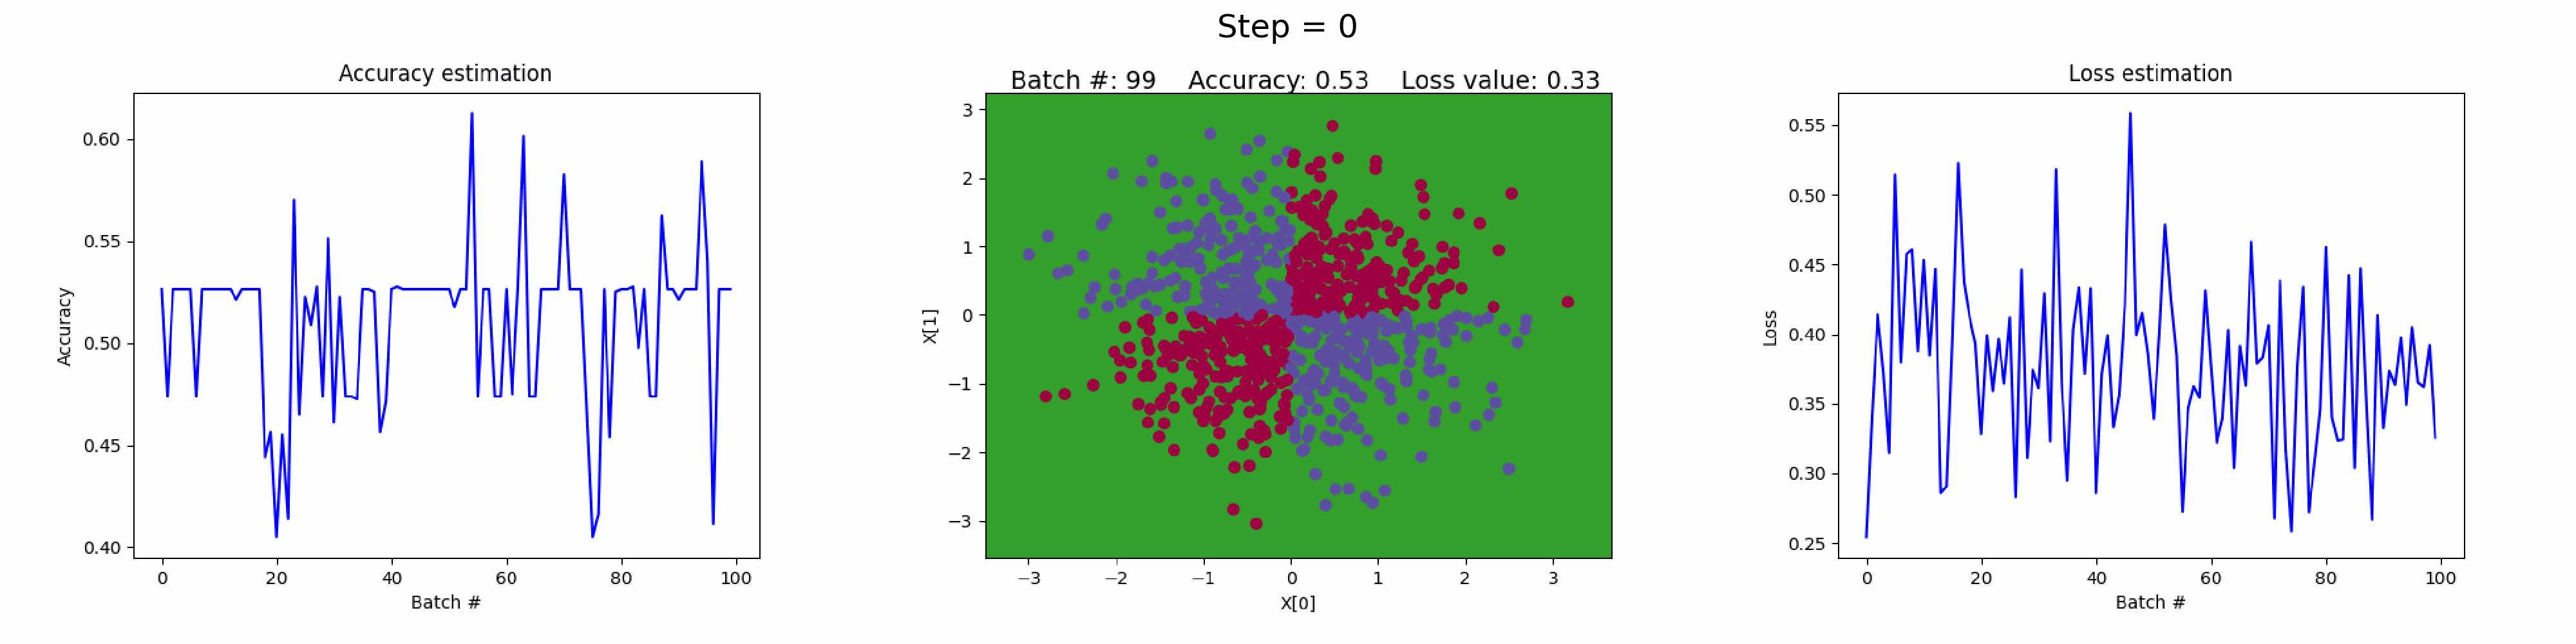

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
input_folder = './scratch_mlp/plots/'
save_filepath = './scratch_mlp/plots/gif/all.gif'
utils.make_all_gif(input_folder, save_filepath)

with open('./scratch_mlp/plots/gif/all.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

In [ ]:
X, y = load_XOR_data(N=800)